<h3>Part 1 -- Autoencoder </h3>
<h5>Each MNIST image is 28 X 28 X 1. This will be compressed to 4 X 4 X 4 using an autoencoder (784 variables to 64 variables).</h5>

In [1]:
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential, load_model

import copy
import matplotlib.pyplot as plt
import numpy as np
import autoencoder_utils as ae_utils

(X_train, _), (X_test, _) = mnist.load_data()

X_train = np.reshape(X_train, (len(X_train), 28, 28, 1)) / 255.
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1)) / 255.


Using TensorFlow backend.


In [29]:
autoencoder = Sequential()

input_shape = (28, 28, 1)
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_shape))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(4, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2), padding='same')) #padding=same here, to maxpool 7*7 to 4*4
autoencoder.add(Conv2D(4, (1, 1), activation='sigmoid', padding='same', name='encoded_layer')) #to convert all to values between 0 and 1, for comparison later on using binary_crossentropy
#at this point, 'encoded' is (4, 4, 4)

autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal'))  #no padding=same here, to convert 16*16 to 14*14
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])

In [33]:
epochs = 30
batch_size = 128

autoencoder.fit(X_train, X_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 23s - loss: 0.1093 - binary_crossentropy: 0.1093 - val_loss: 0.1072 - val_binary_crossentropy: 0.1072
Epoch 2/30
60000/60000 [==============================] - 23s - loss: 0.1074 - binary_crossentropy: 0.1074 - val_loss: 0.1058 - val_binary_crossentropy: 0.1058
Epoch 3/30
60000/60000 [==============================] - 22s - loss: 0.1060 - binary_crossentropy: 0.1060 - val_loss: 0.1043 - val_binary_crossentropy: 0.1043
Epoch 4/30
60000/60000 [==============================] - 23s - loss: 0.1047 - binary_crossentropy: 0.1047 - val_loss: 0.1031 - val_binary_crossentropy: 0.1031
Epoch 5/30
60000/60000 [==============================] - 22s - loss: 0.1034 - binary_crossentropy: 0.1034 - val_loss: 0.1017 - val_binary_crossentropy: 0.1017
Epoch 6/30
60000/60000 [==============================] - 23s - loss: 0.1023 - binary_crossentropy: 0.1023 - val_loss: 0.1014 - val_binary_crossentrop

In [2]:
# from h5py import h5py

# autoencoder.save('autoencoder_MNIST.h5')
# autoencoder = load_model('autoencoder_MNIST.h5')

<h5>
The code below displays the original and autoencoded versions of 10 images.
<br>
They look pretty similar
</h5>

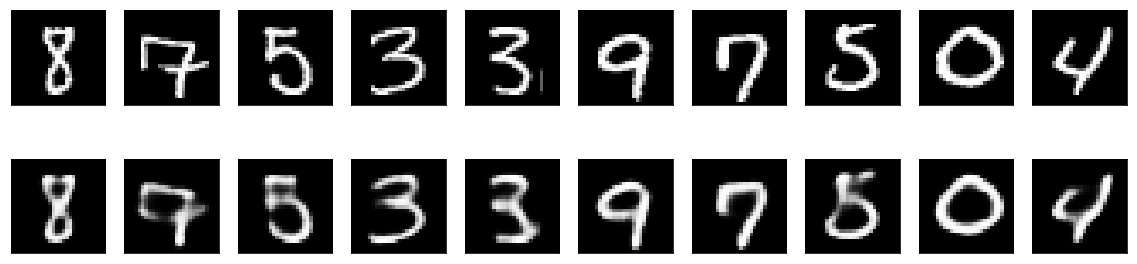

In [4]:
n = 10
img_to_show_idx = np.random.choice(range(X_test.shape[0]), n, replace=False)
X_test_to_show = X_test[img_to_show_idx]
aft_autoencode = autoencoder.predict(X_test_to_show)

fig = plt.figure(figsize=(n*2, 5))
plt.gray()
img_shape = (28, 28)

for i in range(n):
    #display original
    display_single_subplot(X_test_to_show[i].reshape(img_shape), n_row=2, n_col=n, cell_num=i+1)
    #display aft autoencoding
    display_single_subplot(aft_autoencode[i].reshape(img_shape), n_row=2, n_col=n, cell_num=n+i+1)

plt.show()

In [46]:
import importlib
import autoencoder_utils
from autoencoder_utils import *
importlib.reload(autoencoder_utils)

<module 'autoencoder_utils' from 'C:\\Users\\puayn\\Desktop\\Data Science\\Projects\\Basic\\Find similar images using autoencoder network\\autoencoder_utils.py'>

<h3>
Part 2 -- selecting similar images
</h3>
<h5>
Given an image, select the most similar and dissimilar images, using binary cross entropy to determine similarity
</h5>

In [5]:
#find images similar to the image at this index
img_to_find_idx = 0

layer_name = 'encoded_layer'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

similarity_sorted = get_sorted_similarity_idx(encoder, img_to_find_idx, dataset=X_test, loss='binary_crossentropy')

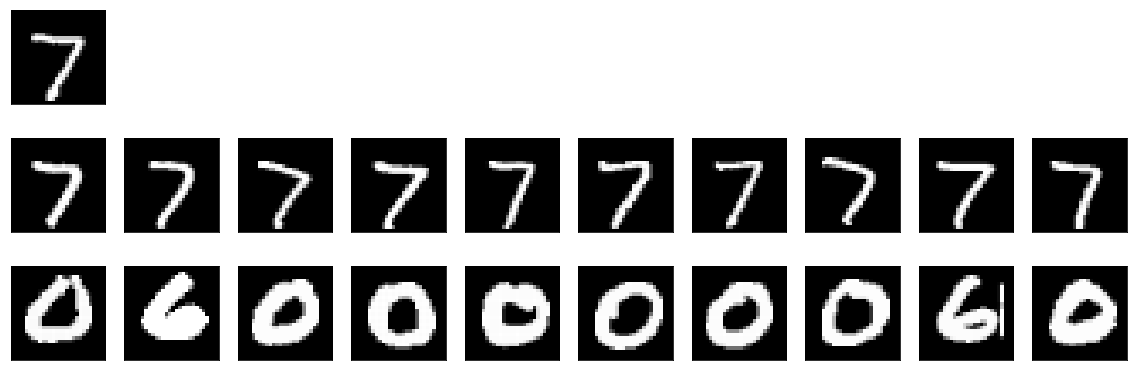

In [6]:
#show original image, n most similar images, n most dissimilar images
n = 10
image_dataset = X_test

plt.figure(figsize=(n*2, n/1.5))
img_shape = (28,28)

#display original
display_single_subplot(image_dataset[img_to_find_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=1)

# #display most similar
for i in range(n):
    similar_idx = similarity_sorted[i]
    display_single_subplot(image_dataset[similar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=n+i+1)

# #display most dissimilar
for i in range(n):
    dissimilar_idx = similarity_sorted[-i-1]
    display_single_subplot(image_dataset[dissimilar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=2*n+i+1)

plt.show()

<h5>Check if this result can handle rotations, shifts, rescaling etc.</h5>

In [49]:
#generates dataset of 21 images - 1 original image, 10 images augmented from the originalimage, 10 images randomly selected from dataset
from keras.preprocessing.image import ImageDataGenerator

#generate n modified images of an image, append n randomly selected image
img_to_test_index = 1
image_dataset = X_test
n=10

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15
    )
datagen.fit(image_dataset)

selected_images = np.zeros((2*n+1,28,28,1))
selected_images[0] = image_dataset[img_to_test_index]

for i in range(n):
    for _, img in enumerate(datagen.flow(image_dataset[img_to_test_index].reshape(1,28,28,1), batch_size=1)):
        selected_images[i+1] = copy.deepcopy(img)
        break

random_selected_img_idx = np.random.choice(image_dataset.shape[0], 10, replace=False)
for i, img_idx in enumerate(random_selected_img_idx):
    selected_images[n+1+i] = (image_dataset[img_idx])

print(selected_images.shape)

(21, 28, 28, 1)


In [56]:
layer_name = 'encoded_layer'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

similarity_sorted = get_sorted_similarity_idx(encoder, 0, dataset=selected_images, loss='binary_crossentropy')

<h5>
Here, we arrange the 20 images (10 augmented from the original image, 10 randomly selected from the wider pool of images), arranged by how similar they are to the original image.
The modified images are mostly deemed to be similar to the original image
</h5>

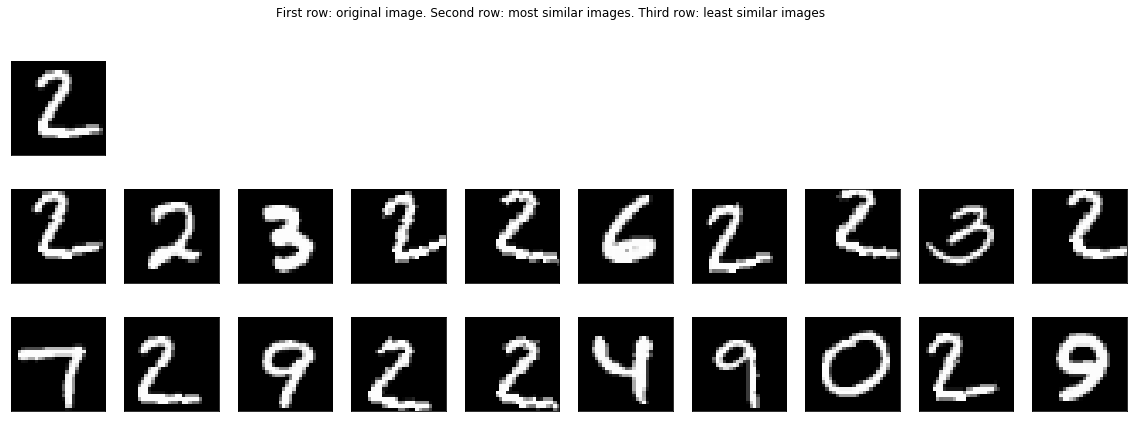

In [57]:
fig = plt.figure(figsize=(n*2, n/1.5))
fig.suptitle('First row: original image. Second row: most similar images. Third row: least similar images')

img_shape = (28, 28)
#display original
display_single_subplot(selected_images[0].reshape(img_shape), n_row=3, n_col=n, cell_num=1)

#display most similar
for i in range(n):
    similar_idx = similarity_sorted[i]
    display_single_subplot(selected_images[similar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=n+i+1)
    
#display most dissimilar
for i in range(n):
    dissimilar_idx = similarity_sorted[-i-1]
    display_single_subplot(selected_images[dissimilar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=2*n+i+1)

plt.show()

<h5>Compare to 'baseline', binary cross entropy comparison of raw image pixels. Will that return decent results?</h5>

In [ ]:
img_to_find_idx = 0
dataset = X_test
#initializing vars to pass into tensorflow
X_selected = [dataset[img_to_find_idx].tolist() for _ in range(dataset.shape[0])]
X_all = dataset.tolist()

X_selected_tf = tf.Variable(X_selected, tf.float32)
X_all_tf = tf.Variable(X_all, tf.float32)
loss_tf = binary_crossentropy(X_selected_tf, X_all_tf)
init_op = tf.global_variables_initializer()

similarity = []
with tf.Session() as sess:
    sess.run(init_op)
    similarity = sess.run(loss_tf)
similarity_sorted = np.argsort(np.array(similarity))[1:] #the same figure appears in X_all too, so remove it

In [ ]:
fig = plt.figure(figsize=(n*2, n/1.5))
fig.suptitle('First row: original image. Second row: most similar images. Third row: least similar images')

img_shape = (28, 28)
#display original
display_single_subplot(selected_images[0].reshape(img_shape), n_row=3, n_col=n, cell_num=1)

#display most similar
for i in range(n):
    similar_idx = similarity_sorted[i]
    display_single_subplot(selected_images[similar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=n+i+1)
    
#display most dissimilar
for i in range(n):
    dissimilar_idx = similarity_sorted[-i-1]
    display_single_subplot(selected_images[dissimilar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=2*n+i+1)

plt.show()